In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Set a random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
num_samples = 10000

# Numeric features
product_id = np.random.choice(range(1, 11), num_samples)
price = np.random.uniform(10, 100, num_samples)
quantity_sold = np.random.randint(50, 500, num_samples)
warehouse_stock = np.random.randint(100, 1000, num_samples)
lead_time_days = np.random.randint(1, 30, num_samples)
promotion_budget = np.random.uniform(1000, 5000, num_samples)

# Target variable
demand = quantity_sold + np.random.randint(-50, 50, num_samples)

# Create a data frame
df = pd.DataFrame({
    'Product_ID': product_id,
    'Price': price,
    'Quantity_Sold': quantity_sold,
    'Warehouse_Stock': warehouse_stock,
    'Lead_Time_Days': lead_time_days,
    'Promotion_Budget': promotion_budget,
    'Demand': demand
})


df


,Product_ID,Price,Quantity_Sold,Warehouse_Stock,Lead_Time_Days,Promotion_Budget,Demand
0,7,98.438717,204,324,21,2530.554641,212
1,4,67.334280,356,242,3,4906.300128,343
2,8,24.547392,164,677,5,3680.812726,133
3,5,91.526445,256,639,21,3639.673333,290
4,7,56.462304,130,224,25,4677.364579,93
...,...,...,...,...,...,...,...
9995,7,81.709557,480,299,1,2772.326728,470
9996,10,85.818772,470,895,21,2408.306426,424
9997,3,46.110700,180,478,20,2963.084063,214
9998,10,48.686117,459,179,21,4600.795608,414


In [79]:

# Select only numeric columns for scaling
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Data preprocessing
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numeric_columns])
tensor_data = torch.tensor(scaled_data, dtype=torch.float32)




import itertools

learning_rates = [0.001,0.01, 0.1]
batch_sizes = [8,16, 32, 64]
hidden_sizes = [16,32, 64, 128, 256]

best_loss = float('inf')
best_params = {}

for lr, batch_size, hidden_size in itertools.product(learning_rates, batch_sizes, hidden_sizes):
    # Hyperparameters
    epochs = 100
    latent_dim = 32

    # Data loader
    data_loader = DataLoader(
        TensorDataset(tensor_data), batch_size=batch_size, shuffle=True
    )

    class DDPMGenerator(nn.Module):
        def __init__(self, input_dim, latent_dim):
            super(DDPMGenerator, self).__init__()

            # Define the generator layers
            self.hidden_layer = nn.Linear(latent_dim, 128)
            self.relu = nn.ReLU()
            self.output_layer = nn.Linear(128, input_dim)

        def forward(self, x):
            # Forward pass
            x = self.hidden_layer(x)
            x = self.relu(x)
            x = self.output_layer(x)
            return x

    # Initialize the model
    generator = DDPMGenerator(
        input_dim=len(numeric_columns), latent_dim=latent_dim
    )

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(generator.parameters(), lr=0.001)

    # Inside your training loop
    total_loss = 0.0  # Initialize total loss
    total_batches = 0  # Count total batches

    for epoch in range(epochs):
        for batch in data_loader:
            original_batch_size = batch[0].size(0)  # Get the actual batch size
            noise = torch.randn(original_batch_size, latent_dim)  # Generate random noise
            optimizer.zero_grad()
            
            # Generate samples using the generator
            generated_data = generator(noise)
            
            # Adjust the size of the target tensor
            target = batch[0]
            
            # Print sizes for debugging
            # print(f"Generated Data Size: {generated_data.size()}, Target Size: {target.size()}")
            
            # Calculate loss
            loss = criterion(generated_data, target)
            
            # Backpropagation
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_batches += 1

        # Print average loss after each epoch
        avg_loss = total_loss / total_batches
        print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {avg_loss}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        best_params = {'lr': lr, 'batch_size': batch_size, 'hidden_size': hidden_size}

print("Best Hyperparameters:", best_params)

Epoch 1/100, Average Loss: 1.0195595791339875
Epoch 2/100, Average Loss: 1.01473894033432
Epoch 3/100, Average Loss: 1.0122549061139425
Epoch 4/100, Average Loss: 1.0104849057912826
Epoch 5/100, Average Loss: 1.0091363058185578
Epoch 6/100, Average Loss: 1.0081590598901113
Epoch 7/100, Average Loss: 1.0073969385419572
Epoch 8/100, Average Loss: 1.0067351131856441
Epoch 9/100, Average Loss: 1.0062411289374034
Epoch 10/100, Average Loss: 1.0058360183286668
Epoch 11/100, Average Loss: 1.0054711164561185
Epoch 12/100, Average Loss: 1.0051719353636106
Epoch 13/100, Average Loss: 1.004911944756141
Epoch 14/100, Average Loss: 1.0047143520832063
Epoch 15/100, Average Loss: 1.0045116249370576
Epoch 16/100, Average Loss: 1.004321632272005
Epoch 17/100, Average Loss: 1.0041545486029457
Epoch 18/100, Average Loss: 1.0040162289116117
Epoch 19/100, Average Loss: 1.0039026400591198
Epoch 20/100, Average Loss: 1.003777974498272
Epoch 21/100, Average Loss: 1.0036786479745592
Epoch 22/100, Average Loss:

real data shape (10000, 7)
Epoch 1/100, Average Loss: 1.0170325477411792
Epoch 2/100, Average Loss: 1.0093993730605788
Epoch 3/100, Average Loss: 1.0086377149174928
Epoch 4/100, Average Loss: 1.006977074085527
Epoch 5/100, Average Loss: 1.005953887465653
Epoch 6/100, Average Loss: 1.0058714238701352
Epoch 7/100, Average Loss: 1.0046513338757168
Epoch 8/100, Average Loss: 1.004252986923145
Epoch 9/100, Average Loss: 1.0052825797135663
Epoch 10/100, Average Loss: 1.003138063819545
Epoch 11/100, Average Loss: 1.0039534807964494
Epoch 12/100, Average Loss: 1.003306346714117
Epoch 13/100, Average Loss: 1.0027991248543855
Epoch 14/100, Average Loss: 1.0030124540541583
Epoch 15/100, Average Loss: 1.0020361121293087
Epoch 16/100, Average Loss: 1.0027726641885795
Epoch 17/100, Average Loss: 1.0028492694447755
Epoch 18/100, Average Loss: 1.002105637720436
Epoch 19/100, Average Loss: 1.0019139518403704
Epoch 20/100, Average Loss: 1.002663242968784
Epoch 21/100, Average Loss: 1.0018057629560968
Ep

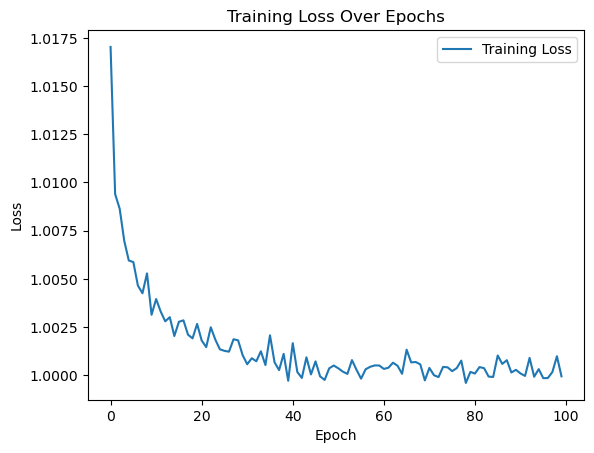

,Product_ID,Price,Quantity_Sold,Warehouse_Stock,Lead_Time_Days,Promotion_Budget,Demand
0,5.510398,53.185623,276.987671,550.050171,14.958650,2992.762939,276.208313
1,5.548499,55.254326,285.213013,547.216736,14.956037,2965.453613,284.725494
2,5.496738,55.159218,276.108246,543.204041,15.104624,3002.293701,275.620972
3,5.407520,54.710457,280.579376,544.266846,14.956352,2983.628174,280.293854
4,5.427393,55.145218,275.097656,546.089355,15.194865,3013.565430,274.637848
...,...,...,...,...,...,...,...
995,5.508618,55.155899,275.347778,546.981628,15.042740,3001.356201,274.998444
996,5.476541,54.676037,274.340088,547.111755,14.943648,3016.466064,274.362579
997,5.510509,55.203033,277.149567,546.570251,14.914454,2994.588867,276.859070
998,5.530908,54.957066,278.125732,551.160645,14.858907,3018.559814,277.279755


In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
np.random.seed(42)

# Generate real data
num_samples = 10000

# Numeric features
product_id = np.random.choice(range(1, 11), num_samples)
price = np.random.uniform(10, 100, num_samples)
quantity_sold = np.random.randint(50, 500, num_samples)
warehouse_stock = np.random.randint(100, 1000, num_samples)
lead_time_days = np.random.randint(1, 30, num_samples)
promotion_budget = np.random.uniform(1000, 5000, num_samples)

# Target variable
demand = quantity_sold + np.random.randint(-50, 50, num_samples)

# Create a data frame
df = pd.DataFrame({
    'Product_ID': product_id,
    'Price': price,
    'Quantity_Sold': quantity_sold,
    'Warehouse_Stock': warehouse_stock,
    'Lead_Time_Days': lead_time_days,
    'Promotion_Budget': promotion_budget,
    'Demand': demand
})

print('real data shape',df.shape)


# Select only numeric columns for scaling
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Data preprocessing
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numeric_columns])
tensor_data = torch.tensor(scaled_data, dtype=torch.float32)




import itertools

learning_rates = 0.01
batch_sizes = 16
hidden_sizes = 32

best_loss = float('inf')
best_params = {}

epochs = 100
latent_dim = 32

# Data loader
data_loader = DataLoader(
    TensorDataset(tensor_data), batch_size=batch_size, shuffle=True
)

class DDPMGenerator(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(DDPMGenerator, self).__init__()

        # Define the generator layers
        self.hidden_layer = nn.Linear(latent_dim, 128)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(128, input_dim)

    def forward(self, x):
        # Forward pass
        x = self.hidden_layer(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

# Initialize the model
generator = DDPMGenerator(
    input_dim=len(numeric_columns), latent_dim=latent_dim
)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(generator.parameters(), lr=0.001)

losses = []

# Inside your training loop
for epoch in range(epochs):
    total_loss = 0.0  # Initialize total loss
    total_batches = 0  # Count total batches

    for batch in data_loader:
        original_batch_size = batch[0].size(0)  # Get the actual batch size
        noise = torch.randn(original_batch_size, latent_dim)  # Generate random noise
        optimizer.zero_grad()
        
        # Generate samples using the generator
        generated_data = generator(noise)
        
        # Adjust the size of the target tensor
        target = batch[0]
        
        # Print sizes for debugging
        # print(f"Generated Data Size: {generated_data.size()}, Target Size: {target.size()}")
        
        # Calculate loss
        loss = criterion(generated_data, target)
        
        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_batches += 1

    # Calculate average loss after each epoch
    avg_loss = total_loss / total_batches
    losses.append(avg_loss)

    # Print average loss after each epoch
    print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {avg_loss}")

# Plot the loss graph
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Generate synthetic data
num_generated_samples = 1000
latent_samples = torch.randn(num_generated_samples, latent_dim)
generated_samples = generator(latent_samples)

# Inverse transform to get the data in the original scale
generated_data_original_scale = scaler.inverse_transform(
    generated_samples.detach().numpy()
)
generated_df = pd.DataFrame(
    generated_data_original_scale, columns=numeric_columns
)

generated_df

In [81]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Assuming real_data and synthetic_data are your DataFrames
real_data = df

synthetic_data = generated_df

# Define features (X) and target variable (y)
features = ['Price', 'Quantity_Sold', 'Warehouse_Stock', 'Lead_Time_Days', 'Promotion_Budget']
target = 'Demand'

# Split the real data into training and testing sets
real_X_train, real_X_test, real_y_train, real_y_test = train_test_split(real_data[features], real_data[target], test_size=0.2, random_state=42)


# Split the synthetic data into training and testing sets
synthetic_X_train, synthetic_X_test, synthetic_y_train, synthetic_y_test = train_test_split(synthetic_data[features], synthetic_data[target], test_size=0.2, random_state=42)


# Convert the target variable to integers for regression
real_y_train_int = real_y_train.astype(int)
real_y_test_int = real_y_test.astype(int)
synthetic_y_train_int = synthetic_y_train.astype(int)
synthetic_y_test_int = synthetic_y_test.astype(int)

# Train XGBoost on real data
real_model_xgb = xgb.XGBRegressor(objective ='reg:squarederror')
real_model_xgb.fit(real_X_train, real_y_train_int)

# Predict on real test data
real_predictions_xgb = real_model_xgb.predict(real_X_test)

# Train XGBoost on synthetic data
synthetic_model_xgb = xgb.XGBRegressor(objective ='reg:squarederror')
synthetic_model_xgb.fit(synthetic_X_train, synthetic_y_train_int)

# Predict on synthetic test data
synthetic_predictions_xgb = synthetic_model_xgb.predict(synthetic_X_test)


from sklearn.metrics import mean_absolute_error

print("Mean Absolute Error:")
print("Real Data:", mean_absolute_error(real_y_test, real_predictions_xgb))
print("Synthetic Data:", mean_absolute_error(synthetic_y_test, synthetic_predictions_xgb))

from sklearn.metrics import r2_score

print("R-squared:")
print("Real Data:", r2_score(real_y_test, real_predictions_xgb))
print("Synthetic Data:", r2_score(synthetic_y_test, synthetic_predictions_xgb))

from sklearn.metrics import explained_variance_score

print("Explained Variance Score:")
print("Real Data:", explained_variance_score(real_y_test, real_predictions_xgb))
print("Synthetic Data:", explained_variance_score(synthetic_y_test, synthetic_predictions_xgb))



Mean Absolute Error:
Real Data: 25.719999982357024
Synthetic Data: 0.5903659
R-squared:
Real Data: 0.9476087698822835
Synthetic Data: 0.9005069682853953
Explained Variance Score:
Real Data: 0.9476165953424291
Synthetic Data: 0.9573671817779541
